

connect dataset



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Libraries**

In [ ]:
import tensorflow as tf
from keras.layers.core import Dropout, Lambda
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import cv2
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
import pandas as pd
from skimage.transform import resize
from tqdm import tqdm
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from keras.layers.merge import concatenate
from keras.optimizers import Nadam, Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint


**Folders path**

In [ ]:
training_folder = "/content/drive/MyDrive/computing project/ISIC-2017_Training_Data/ISIC-2017_Training_Data"
training_mask_folder = "/content/drive/My Drive/computing project/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth"
test_folder = "/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data"
training_folder_resize="/content/drive/MyDrive/computing project/training_folder_resize"
training_mask_folder_resize="/content/drive/MyDrive/computing project/training_mask_folder_resize"
test_folder_resize="/content/drive/MyDrive/computing project/test_folder_resize"
test_mask_folder="/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part1_GroundTruth"
test_mask_folder_resize="/content/drive/MyDrive/computing project/test_folder_mask_resize"
training_Otsu_images="/content/drive/MyDrive/computing project/Trainig_otsu"
training_Otsu_images_resize="/content/drive/MyDrive/computing project/train_otsu-resize"
test_Otsu_images="/content/drive/MyDrive/computing project/test_Otsu_images"
test_Otsu_images_resize="/content/drive/MyDrive/computing project/test_otsu-resize"
Train_labl="/content/drive/MyDrive/computing project/ISIC-2017_Training_GroundTruth.csv"
test_lable="/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_GroundTruth.csv"

**Images IDS**

In [ ]:
#training images and masks ids
train_im=  pd.read_csv("/content/drive/MyDrive/computing project/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv")
train_ids=train_im['image_id']
Train_mask_ids= train_im['image_id']+'_segmentation'
#testing image and mask ids
test_im= pd.read_csv("/content/drive/MyDrive/computing project/ISIC-2017_Test_v2_GroundTruth.csv")
test_ids=test_im['image_id']
test_mask_ids= test_im['image_id']+'_segmentation'

**resize images**

In [ ]:
def resize_images(path,ids,saving_path,image_type):
 sys.stdout.flush()
 for id in tqdm(ids) :
   img = imread(path + '/' + id + '.'+image_type)
   if img.shape[0]>128 and img.shape[1]>128:
      img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
      cv2.imwrite(saving_path+'/'+id+'.'+image_type,img)
  
 print('done!')
 return

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

**get images and mask**

In [ ]:
def get_images(path,IDs):
  X = np.zeros((len(IDs), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
  sys.stdout.flush()
  for n, id in tqdm(enumerate(IDs), total=len(IDs)):
    img = imread(path + '/' + id + '.jpg')[:,:,:IMG_CHANNELS]
    X[n] = img
  return X

In [ ]:
def get_mask(path,IDs):
  Y = np.zeros((len(IDs), IMG_HEIGHT, IMG_WIDTH, 1))
  sys.stdout.flush()
  for n, id in tqdm(enumerate(IDs), total=len(IDs)):
    img = imread(path + '/' + id + '.png')
    img= np.expand_dims(img,axis=-1)
    Y[n] = img
  return Y 

**normalizaion**

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask = input_mask
  return input_image, input_mask

**Loding the train images with the mask**

In [ ]:
def load_image_train(imgs,mask,id,ids):
  input_image = get_images(imgs,id)
  input_mask = get_mask(mask,ids)

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

loading the test images with the mask

In [ ]:
def load_image_test(imgs,mask,id,ids):
  input_image = get_images(imgs,id)
  input_mask = get_mask(mask,ids)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
train = load_image_train(training_folder_resize,training_mask_folder_resize,train_ids,Train_mask_ids)
test =  load_image_test(test_folder_resize,test_mask_folder_resize,test_ids,test_mask_ids)


100%|██████████| 600/600 [02:42<00:00,  3.69it/s]


In [ ]:
print('train images = ',len(train[0]),'training mask =',len(train[1]))
print('testing images =' ,len(test[0]),'testing mask=',len(test[1]))


train images =  2000 training mask = 2000
testing images = 600 testing mask= 600


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

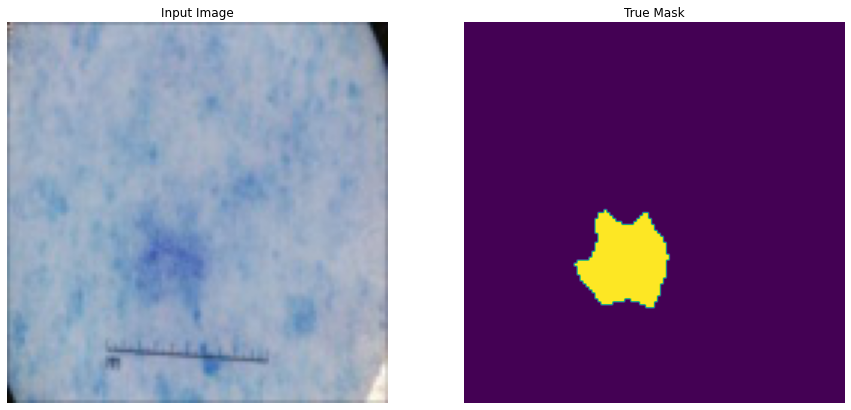

In [ ]:
r= random.randint(0,2000)
for image, mask in train,:
  sample_image, sample_mask = image[r], mask[r]
display([sample_image, sample_mask])


# **Building our U-Net Mode**

In [ ]:
def model():
    inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [ ]:
model = model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 16)   432         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 16)   64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 16)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

**Define the custom Metric**

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Train the model

In [ ]:
opt = tf.keras.optimizers.Nadam(1e-4)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

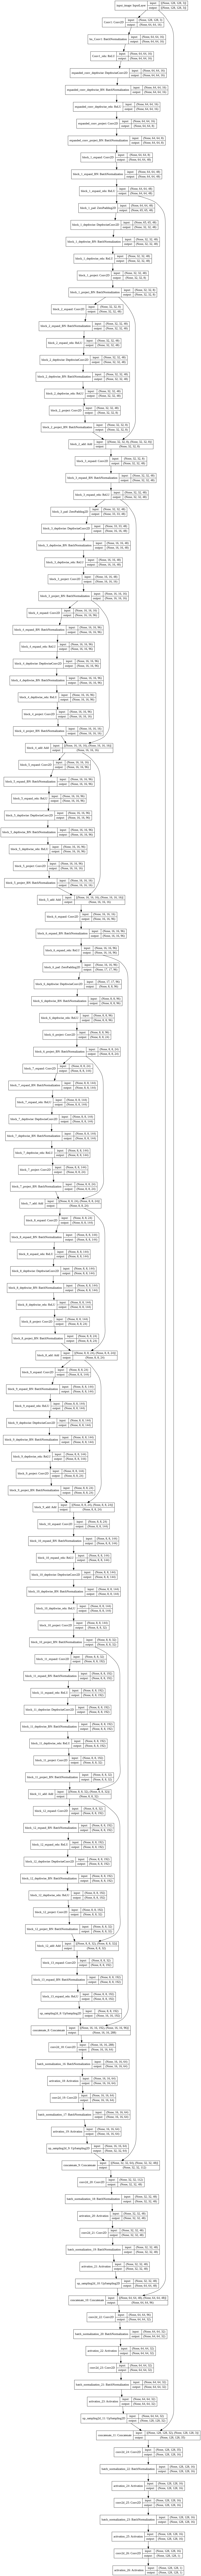

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)


**show predicts before training**

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for i in range(num):
     for image, mask in dataset,:
       pred_mask = model.predict(image)
       display([image[i], mask[i], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


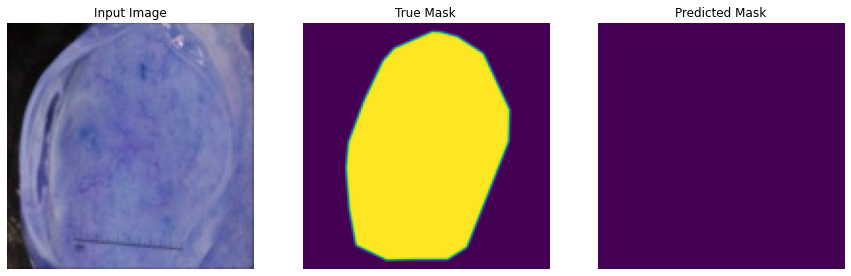

In [ ]:
show_predictions(test)


**Fit our model**

In [ ]:
model_path = "/content/drive/MyDrive/computing project/assets/cancer_finder_unet_1.h5"
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

# Fit our model 
results = model.fit(train[0],train[1], validation_split=0.2,
                    batch_size=16, epochs=100, 
                    callbacks=[earlystop, checkpoint])



Epoch 1/100
100/100 [==============================] - 18s 71ms/step - loss: -0.9823 - dice_coef: 1.9823 - recall_8: 0.9991 - precision_10: 0.4998 - val_loss: -0.9612 - val_dice_coef: 1.9612 - val_recall_8: 0.9893 - val_precision_10: 0.4843

Epoch 00001: val_loss improved from inf to -0.96123, saving model to /content/drive/MyDrive/computing project/assets/cancer_finder_unet_1.h5
Epoch 2/100
100/100 [==============================] - 6s 61ms/step - loss: -0.9846 - dice_coef: 1.9846 - recall_8: 0.9995 - precision_10: 0.5523 - val_loss: -0.9636 - val_dice_coef: 1.9636 - val_recall_8: 0.9898 - val_precision_10: 0.4979

Epoch 00002: val_loss improved from -0.96123 to -0.96360, saving model to /content/drive/MyDrive/computing project/assets/cancer_finder_unet_1.h5
Epoch 3/100
100/100 [==============================] - 6s 61ms/step - loss: -0.9852 - dice_coef: 1.9852 - recall_8: 0.9995 - precision_10: 0.5795 - val_loss: -0.9535 - val_dice_coef: 1.9535 - val_recall_8: 0.9846 - val_precision_1

In [ ]:
model = load_model('/content/drive/MyDrive/computing project/assets/cancer_finder_unet_1.h5',
                   custom_objects={'dice_loss':dice_loss,'dice_coef':dice_coef})

preds_test = model.predict(test[0], verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)




19/19 [==============================] - 1s 25ms/step


**showing our prediction **

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


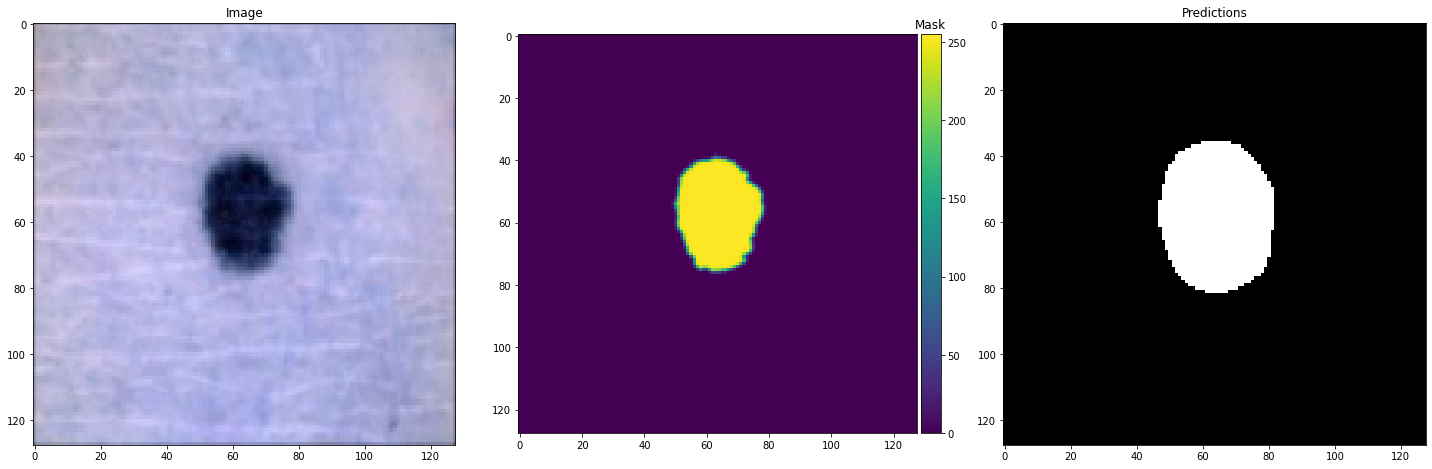

In [ ]:
# Ploting our predicted masks
ix = random.randint(0, 600)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
plt.imshow(test[0][ix])
plt.title("Image")

# Our original combined mask  
plt.subplot(132)
imshow(np.squeeze(test[1][ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_test_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

In [ ]:
def show_predictions2(dataset=None, num=1):
  if dataset:
    for i in range(num):
     for image, mask in dataset,:
        pred_mask =preds_test_t[i] 
        display([image[i], mask[i], pred_mask])


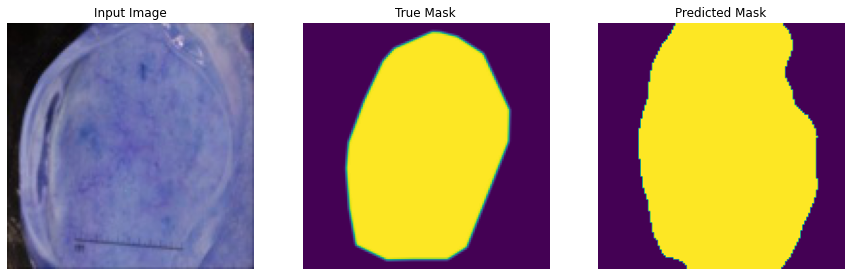

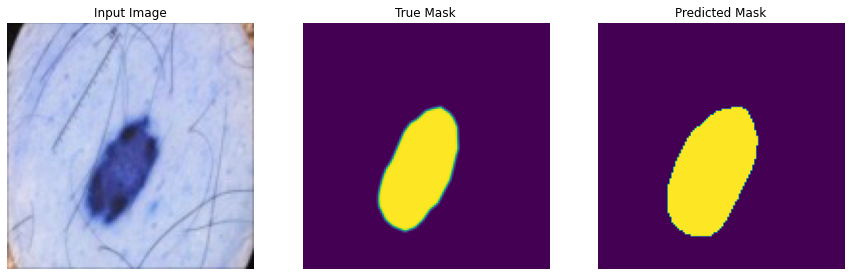

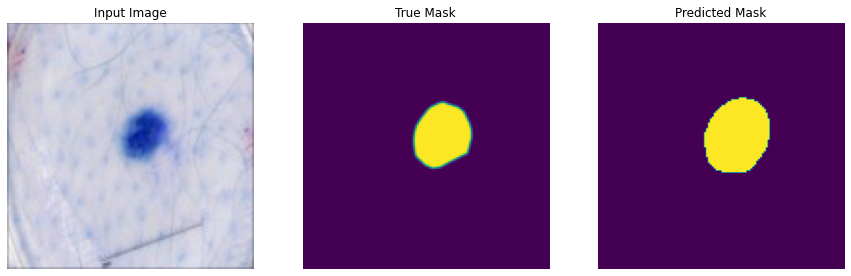

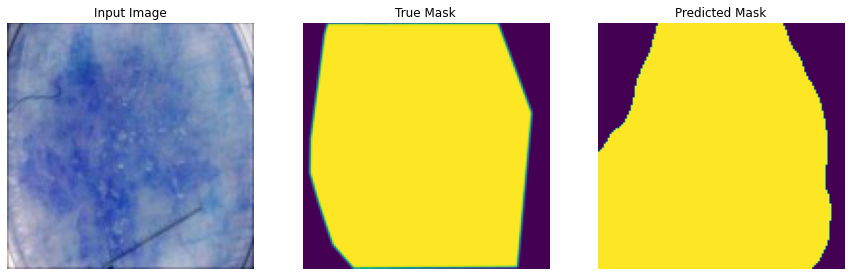

In [ ]:
show_predictions2(test , 4)